## Imports and data-reading

In [2]:
import pandas as pd
# !pip install cvxopt
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.svm import SVC
from sklearn import datasets
import random
import time

## Useful Functions for any part

### For SVM/SVC plotting

In [15]:
def plot_it_all_rbf(train_X, train_y, test_X, test_y, reg_pam, ker_coeff_pam):

    ######################################### 3D plot ########################################
    Z = np.ones((len(reg_pam),len(ker_coeff_pam)))
    W = np.ones((len(reg_pam),len(ker_coeff_pam)))
    X, Y = np.meshgrid(reg_pam, ker_coeff_pam)


    for idxc, c in enumerate(reg_pam):
        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
#             mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            Z[idxc][idxg] = mod.score(train_X, train_y)
            W[idxc][idxg] = mod.score(test_X, test_y)

    # print(X, Y, Z, W, X.shape, Y.shape, Z.shape, W.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(np.log10(X), np.log10(Y), Z, rstride=1, cstride=1, label='train', color='blue' )
    ax.plot_wireframe(np.log10(X), np.log10(Y), W, rstride=1, cstride=1, label='test', color='red')
    #ax.plot_surface(np.log10(X), np.log10(Y), Z, rstride=1, cstride=1, label='train', cmap='viridis', edgecolor='none' )
    #ax.plot_surface(np.log10(X), np.log10(Y), W, rstride=1, cstride=1, label='test', cmap='viridis', edgecolor='none')
    #ax.contour(np.log10(X), np.log10(Y), Z, label='train', cmap='viridis')
    #ax.contour(np.log10(X), np.log10(Y), W, label='test', cmap='viridis')
    #ax.colorbar()
    ax.set_title('Poly kernel: C and Gamma Vs Accuracy')
    ax.set_xlabel('log(C)')
    ax.set_ylabel('log(Gamma)')

    plt.legend()
    plt.show()


    ######################################## My conventional plots ########################################
    for idxc, c in enumerate(reg_pam):
        E_score_train = []
        E_score_test = []

        for idxg, g in enumerate(ker_coeff_pam):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly', C = c, gamma = g))]
            pipeline = Pipeline(ppl) 
            mod = pipeline
            #mod = svm.SVC(kernel='poly', C = c, gamma = g)
            mod.fit(train_X, np.ravel(train_y, order='C'))
            E_score_train.append(mod.score(train_X, train_y))
            E_score_test.append(mod.score(test_X, test_y))

        plt.plot(ker_coeff_pam, E_score_test, "r-", label="Test")
        plt.plot(ker_coeff_pam, E_score_train, "b-", label="Train")
        plt.xscale('log')
        plt.xlabel(r'$\Gamma$')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Score for C=%s'%(c))
        plt.show()


        
def plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam):

    ######################################## My conventional plots ########################################
    E_score_train = []
    E_score_test = []

    for idxc, c in enumerate(reg_pam):    
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear', C = c))]
        pipeline = Pipeline(ppl) 
        mod = pipeline
#         mod = svm.SVC(kernel='poly', C = c, gamma = g)
        mod.fit(train_X, np.ravel(train_y, order='C'))
        E_score_train.append(mod.score(train_X, train_y))
        E_score_test.append(mod.score(test_X, test_y))

    plt.plot(reg_pam, E_score_test, "r-", label="Test")
    plt.plot(reg_pam, E_score_train, "b-", label="Train")
    plt.title("Score Vs C for LIBSVM")
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Score')
    plt.legend()
#     plt.title('Score for C=%s'%(c))
    plt.show()

        
        
        
######################################## PLOTS FOR GRID SEARCH ########################################

def plot_search_results(grid):
    # Reference: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    """
    Params: 
        grid: A trained GridSearchCV object.
    For plotting the results when tuning several hyperparameters, 
    I fixed all parameters to their best value except for one and 
    plotted the mean score for the other parameter for each of its values.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey=False,figsize=(len(params)*10,len(params)*2.5))
    fig.suptitle('Score per parameter')
    fig.text(0.085, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
#         m=np.array(masks[:i])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        if (x[-1]>=x[-2]*9):
            ax[i].set_xscale('log')
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid(True)
        ax[i].legend()

    #plt.legend()
    plt.show()


    
def plot_search_results_linear(grid, reg_pam):
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

#     print("")
    # print('mean_test_score: ', means_test)
    # print('std_test_score: ', stds_test)
    # print('mean_train_score: ', means_train)
    # print('std_train_score: ', stds_train)
    x = reg_pam
    y_1 = np.array(means_test)
    e_1 = np.array(stds_test)
    y_2 = np.array(means_train)
    e_2 = np.array(stds_train)
    plt.errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
    plt.errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
    plt.grid(True)
    plt.xscale('log')
    plt.title('Score Vs C for CVXOPT')
    plt.legend(loc='lower right')
    plt.ylabel('Score')
    plt.xlabel('C')
    plt.show()

### For CVXOPT

In [3]:
# Reference: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
# Reference: https://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf

def cvx_try(X, y, X_test, y_test, which, C=1.0, gamma=0.04, coef0= 0.0, degree=3, threshold=1e-4):
    
    # Linear: C
    # Poly: C, Gamma, Degree, Coef0
    # Sigmoid: C, Gamma, Coef0
    # RBF: C, gamma
    
    def makeHP(X1, X2, y_temp, which):
        H = np.dot(X1, X2.T)
        if (which=='linear'):
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='poly'):
            H = (gamma*H+coef0)**degree
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='sigmoid'):
            H = np.tanh(gamma*H+coef0)
            P = matrix(y_temp.dot(y_temp.T)*H)
        elif (which=='rbf'):
            H1 = np.diag(X1.dot(X1.T)).reshape(-1, 1)*np.ones((1, X2.shape[0]))
            H2 = np.diag(X2.dot(X2.T)).reshape(1, -1)*np.ones((X1.shape[0],1))
            H = 2*H-H1-H2
            H = np.exp(gamma*H)
            P = matrix(y_temp.dot(y_temp.T)*H)
    
        return H,P
    
    y_temp = y.reshape(-1, 1)*1.
    H,P = makeHP(X, X, y_temp, which)
    q = matrix(-np.ones((X.shape[0], 1)))
    A = matrix(y_temp.reshape(1, -1))
    b = matrix(np.zeros(1))
    G = matrix(np.r_[-1*(np.eye(X.shape[0])), np.eye(X.shape[0])])
    h = matrix(np.r_[np.zeros(X.shape[0]), np.ones(X.shape[0])*C])
    #print(repr(q),repr(A),repr(b),repr(G),repr(h))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    lambs, _ = np.array(sol['x']), np.array(sol['primal objective'])
    
    
    ########## GET SUPPORT VECTORS ################
    idx = np.where(lambs > threshold)[0] # Indices of support vectors
    #Extract support vectors
    sX = X[idx,:]
    sy = y[idx]
    lambs = lambs[idx]
    b = np.sum(sy)
    for j in idx:
        b = b - np.sum(lambs*sy*(H[j, idx].reshape(-1, 1)))
    b /= idx.shape[0]
    
    
    
    ######### PREDICT ###########
    ynew = np.zeros((X_test.shape[0],))
    Htemp,_ = makeHP(sX, test_X, ynew, which)
    rightcnt = 0.
#     print(ynew.shape, Htemp.shape)
    for i in range(ynew.shape[0]):
        ynew[i] = np.sum(lambs*sy*Htemp[:,i].reshape(-1,1))+b
        if (ynew[i]*y_test[i]>0):
            rightcnt+=1.
    y_pred = np.sign(ynew)
    score = rightcnt*100.0/ynew.shape[0]
    
    
    
    return lambs, sX, sy, y_pred, score

# Part 1

### CVX something and warnings filter

In [4]:
# # cvx_try(X, y, X_test, y_test, which, C=1.0, gamma=0.04, coef0= 0.0, degree=3, threshold=1e-4):
# legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='poly', C=0.01, gamma=1000, degree=1)


# # threshold = 1e-4
# # ############ https://xavierbourretsicotte.github.io/SVM_implementation.html #########
# # #w parameter in vectorized form
# # w = ((train_y * idk).T @ train_X).reshape(-1,1)
# # #Selecting the set of indices S corresponding to non zero parameters
# # S = (idk > threshold).flatten()
# # #Computing b
# # b = train_y[S] - np.dot(train_X[S], w)
# # #Display results
# # # print('Alphas = ',idk[idk > threshold])
# # print('w = ', w.flatten())
# # print('b = ', b[0])

# # suppV = (suppX, suppy)
# # print("Support vectors: ", suppV)
# print("Support vectors: ", sorted(suppX, key=lambda x: x[0]))
# print("CVX score: ", acc)
import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
# warnings.resetwarnings()
warnings.filterwarnings("ignore")

# Part 1A (Binary)

## Death by pipeline

In [ ]:
file_name = '2019EE10143.csv'
random_state = 69420
# split_frac = 0.8
# low_reg, high_reg = -3,2
# low_cof, high_cof = -3,1
# low_deg, high_deg = 1,4
split_frac = 0.1
low_reg, high_reg = -1,1
low_cof, high_cof = -1,1
low_deg, high_deg = 1,2

reg_pam = np.logspace(low_reg, high_reg, num=1+high_reg-low_reg)
ker_coeff_pam = np.logspace(low_cof, high_cof, num=1+high_cof-low_cof)
deg_pam = np.linspace(low_deg, high_deg, 1+high_deg-low_deg)


df = pd.read_csv(file_name, header=None)
pairs = [(0,1), (4,6), (8,9)]
# pairs = [(8,9)]
features = [10,25]
typ = ['linear','poly','rbf','sigmoid']
for (lab1, lab2) in pairs:
    for num_ft in features:
        for which in typ:
            print("#################################################################################")
            print("Labels:",lab1, ",", lab2)
            print("Number of features:", num_ft)
            print("#################################################################################")

            #CONVERT TO USE
            df_temp = df.loc[df[25].isin([lab1, lab2])]
            #print(len(df_temp))
            df_temp.iloc[df_temp[25] == lab1, 25] = -1
            df_temp.iloc[df_temp[25] == lab2, 25] = 1
            df_temp = df_temp.sample(frac=1., random_state=random_state)

            # SPLIT IN TRAIN AND TEST
            train_df = df_temp[:int(split_frac*len(df_temp))]
            test_df = df_temp[int(split_frac*len(df_temp)):]

            # SPLIT BY FEATURES
            X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
            y_train_temp = train_df.loc[:, [25]]
            X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
            y_test_temp = test_df.loc[:, [25]]



            train_X = np.array(X_train_temp.values)
            train_y = np.array(y_train_temp.values)
            test_X = np.array(X_test_temp.values)
            test_y = np.array(y_test_temp.values)

            print ("Number of training examples:", train_X.shape, train_y.shape)
            print ("Number of test examples:", test_X.shape, test_y.shape)


            # SVM STUFF & GRID SEARCH CV
            print("--------------------------LIBSVM for {ty}-----------------------------".format(ty=which.upper()))
            
            if (which=='linear'):
                ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear'))]
                parameters = {'SVM__C':reg_pam} #Linear
            elif (which=='rbf' or which=='sigmoid'):
                ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel=which))]
                parameters = {'SVM__C':reg_pam, 'SVM__gamma':ker_coeff_pam} #RBF/SIGMOID
            elif (which=='poly'):
                ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly'))]
                parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly
            
            pipeline = Pipeline(ppl) 
            #parameters = {'SVM__C':reg_pam} #Linear
            #parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly
            #parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam}
            grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, return_train_score=True, verbose=0)

            grid.fit(train_X, np.ravel(train_y, order='C'))
            #print(grid.score(train_X, train_y))
            #print(grid.score(test_X, test_y))
            bestpar = grid.best_params_
            print("The Best parameters according to grid search are:", bestpar)
            
            
            if (which=='linear'):
                mod = svm.SVC(kernel='linear', C = bestpar['SVM__C']) #Linear
            elif (which=='rbf' or which=='sigmoid'):
                mod = svm.SVC(kernel=which, C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma']) #RBF/SIGMOID
            elif (which=='poly'):
                mod = svm.SVC(kernel='poly', C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma'], degree= bestpar['SVM__degree']) #Poly


            mod.fit(train_X, np.ravel(train_y, order='C'))
            print("Training score for LIBSVM with best parameters:", 100*mod.score(train_X, train_y), "%")
            print("Test score for LIBSVM with best parameters:", 100*mod.score(test_X, test_y), "%")
            ab,a_ind,b_ind=np.intersect1d(train_X, mod.support_vectors_, return_indices=True)
            a_ind = sorted(a_ind)
            boi = []
            for i in range(0, len(a_ind), num_ft):
                boi.append(a_ind[i]//num_ft)
            
            print("Indices of support vectors as returned by LIBSVM: ", boi)
            
            print()
            print()
            print()

            # CVXOPT STUFF
            print("--------------------------CVXOPT for {ty}-----------------------------".format(ty=which.upper()))
            
            flag=True
            if (which=='linear'):
                legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='linear', C=bestpar['SVM__C']) #Linear
            elif (which=='rbf' or which=='sigmoid'):
                try:
                    legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which=which, C=bestpar['SVM__C'], gamma = bestpar['SVM__gamma']) #RBF/Sigmoid
                except:
                    flag=False
                    print("An exception occurred for {ty} at params C={c}, gamma={gam}".format(ty=which.title(), c=bestpar['SVM__C'], gam=bestpar['SVM__gamma']))
            elif (which=='poly'):
                legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='poly', C=bestpar['SVM__C'], gamma = bestpar['SVM__gamma'], degree= bestpar['SVM__degree']) #Poly

            if (flag==True):
                print("Test score for CVXOPT with best parameters:", acc, "%")
                ab,a_ind,b_ind=np.intersect1d(train_X, suppX, return_indices=True)
                a_ind = sorted(a_ind)
                boi = []
                for i in range(0, len(a_ind), num_ft):
                    boi.append(a_ind[i]//num_ft)
                print("Indices of support vectors as returned by CVXOPT: ", boi)
            


            # PLOTTINGS
            if (which=='linear'):
                plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam) #Linear. Nothing for anything else. Can use other one for RBF
                plot_search_results_linear(grid, reg_pam) #Linear
            else:
                plot_search_results(grid) #For non-linear or any with multiple parameters

            print()
            print()
            print()
            print()
            print()
            print()

# PART 1A (Multi-class)

## Death by pipeline

In [ ]:
file_name = '2019EE10143.csv'
random_state = 69420
split_frac = 0.8
low_reg, high_reg = -2,1
low_cof, high_cof = -3,1
low_deg, high_deg = 1,4
# split_frac = 0.1
# low_reg, high_reg = -1,1
# low_cof, high_cof = -1,1
# low_deg, high_deg = 1,2

reg_pam = np.logspace(low_reg, high_reg, num=1+high_reg-low_reg)
ker_coeff_pam = np.logspace(low_cof, high_cof, num=1+high_cof-low_cof)
deg_pam = np.linspace(low_deg, high_deg, 1+high_deg-low_deg)

df = pd.read_csv(file_name, header=None)

features = [10,25]
typ = ['linear','sigmoid','rbf','poly']
for num_ft in features:
    for which in typ:
        print("#####################################################################")
        print("Number of features:", num_ft)
        print("#####################################################################")

        #CONVERT TO USE
        # df_temp = df.loc[df[25].isin([lab1, lab2])]
        # print(len(df_temp))
        # df_temp.iloc[df_temp[25] == lab1, 25] = -1
        # df_temp.iloc[df_temp[25] == lab2, 25] = 1
        df_temp = df.sample(frac=1., random_state=random_state)

        # SPLIT IN TRAIN AND TEST
        train_df = df_temp[:int(split_frac*len(df_temp))]
        test_df = df_temp[int(split_frac*len(df_temp)):]

        # SPLIT BY FEATURES
        X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
        y_train_temp = train_df.loc[:, [25]]
        X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
        y_test_temp = test_df.loc[:, [25]]



        train_X = np.array(X_train_temp.values)
        train_y = np.array(y_train_temp.values)
        test_X = np.array(X_test_temp.values)
        test_y = np.array(y_test_temp.values)

        print ("Number of training examples:", train_X.shape, train_y.shape)
        print ("Number of test examples:", test_X.shape, test_y.shape)


        # SVM STUFF & GRID SEARCH CV
        print("--------------------------LIBSVM for {ty} for {ft} features-----------------------------".format(ty=which.upper(), ft=num_ft))

        if (which=='linear'):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear'))]
            parameters = {'SVM__C':reg_pam} #Linear
        elif (which=='rbf' or which=='sigmoid'):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel=which))]
            parameters = {'SVM__C':reg_pam, 'SVM__gamma':ker_coeff_pam} #RBF/SIGMOID
        elif (which=='poly'):
            ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly'))]
            parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly

        pipeline = Pipeline(ppl) 
        #parameters = {'SVM__C':reg_pam} #Linear
        #parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly
        #parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam}
        grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, return_train_score=True, verbose=0)

        grid.fit(train_X, np.ravel(train_y, order='C'))
        bestpar = grid.best_params_
        print("The Best parameters according to grid search are:", bestpar)
        print("Best training score from grid search pipeline:",100*grid.score(train_X, train_y), "%")
        print("Best test score from grid search pipeline:",100*grid.score(test_X, test_y), "%")
        

        if (which=='linear'):
            mod = svm.SVC(kernel='linear', C = bestpar['SVM__C']) #Linear
        elif (which=='rbf' or which=='sigmoid'):
            mod = svm.SVC(kernel=which, C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma']) #RBF/SIGMOID
        elif (which=='poly'):
            mod = svm.SVC(kernel='poly', C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma'], degree= bestpar['SVM__degree']) #Poly


        mod.fit(train_X, np.ravel(train_y, order='C'))
        print("Training score for LIBSVM with best parameters:", 100*mod.score(train_X, train_y), "%")
        print("Test score for LIBSVM with best parameters:", 100*mod.score(test_X, test_y), "%")
        
        print()
        print()
        print()

        # PLOTTINGS
        if (which=='linear'):
            plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam) #Linear. Nothing for anything else. Can use other one for RBF
            plot_search_results_linear(grid, reg_pam) #Linear
        else:
            plot_search_results(grid) #For non-linear or any with multiple parameters

        print()
        print()

# PART 1B

## Simplified SMO

### Functions

In [7]:
def getKer(X1, X2, which, gamma, coef0=0., degree=3):
    H = np.dot(X1, X2.T)
    if (which=='linear'):
        H = H
    elif (which=='poly'):
        H = (gamma*H+coef0)**degree
    elif (which=='sigmoid'):
        H = np.tanh(gamma*H+coef0)
    elif (which=='rbf'):
        H1 = np.diag(X1.dot(X1.T)).reshape(-1, 1)*np.ones((1, X2.shape[0]))
        H2 = np.diag(X2.dot(X2.T)).reshape(1, -1)*np.ones((X1.shape[0],1))
        H = 2*H-H1-H2
        H = np.exp(gamma*H)
    return H
    
def simplifiedSMO(C, tol, max_passes, X, y, gamma, which='linear'):
    # y = y.T
    m,n =X.shape[0], X.shape[1]
    alphas = np.zeros((m,1))
    b = 0
    passes = 0
    while (passes < max_passes):
        num_changed_alphas = 0
        for i in range(m):
            # Calculate Ei = f(xi) - yi using 2
            fxi = ((alphas*y).T@(getKer(X,X[i,:], which, gamma)))*1. + b #single value
            # print(fxi)
            Ei = fxi-y[i] #Single value
            # print(y[i].shape, Ei.shape)
            flag1 = (y[i]*Ei<-tol) and (alphas[i]<C)
            flag2 = (y[i]*Ei>tol) and (alphas[i]>0)
            if (flag1) or (flag2):
                # select j != i randomly
                j=int(random.uniform(0,m))
                while (j==i):
                    j=int(random.uniform(0,m))
                # Calculate Ej = f(xj) - yj
                fxj = ((alphas*y).T@getKer(X,X[j,:], which, gamma))*1. + b
                Ej = fxj - y[j]
                # save old alphas
                alpha_i_old, alpha_j_old = alphas[i].copy(), alphas[j].copy() #To avoid previous values from being changed. Not sure if it happens
                # compute L and H by 10 or 11
                if (y[i]!=y[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # if L = H the continue to next i
                if L==H:
                    continue
                # compute eta by 14
                eta = 2.*getKer(X[i,:],X[j,:], which, gamma) - getKer(X[i,:],X[i,:], which, gamma) - getKer(X[j,:],X[j,:], which, gamma)
                # if eta >= 0: continue to next i
                if eta>=0:
                    continue
                # compute and clip new value for alpha_{j} using 12 and 15
                alphas[j] -= y[j]*(Ei-Ej)/eta
                if (alphas[j]>H):
                    alphas[j]=H
                elif (L>alphas[j]):
                    alphas[j]=L
                # if |alphasj - alphasold| < 1e-5 then continue to next i
                if (abs(alphas[j]-alpha_j_old) < 0.00001):
                    continue
                # determine value for alpha_{i} using 16
                alphas[i] += y[j]*y[i]*(alpha_j_old-alphas[j])
                # compute b1 and b2 using (17) and (18) respectively.
                b1 = b - Ei- y[i]*(alphas[i]-alpha_i_old)*getKer(X[i,:],X[i,:], which, gamma) - y[j]*(alphas[j]-alpha_j_old)*getKer(X[i,:],X[j,:], which, gamma)
                b2 = b - Ej- y[i]*(alphas[i]-alpha_i_old)*getKer(X[i,:],X[j,:], which, gamma) - y[j]*(alphas[j]-alpha_j_old)*getKer(X[j,:],X[j,:], which, gamma)
                # compute b by 19
                if (0<alphas[i]) and (alphas[i]<C):
                    b = b1
                elif (0 < alphas[j]) and (alphas[j]<C):
                    b = b2
                else:
                    b = (b1 + b2)/2.                     
                num_changed_alphas+=1
        if (num_changed_alphas==0):
            passes+=1
        else: 
            passes=0
            
    return alphas, b

def iNeedWeight(alphas, X, y):
    """
    w = sum(i=1 to m) yi*alphai*xi
    """
    wt = np.zeros((X.shape[1],))
    # print(alphas[0].shape, y[0].shape, X[0,:].T.shape)
    for i in range(X.shape[0]):
        wt += (alphas[i]*y[i])*(X[i,:].T)
    return wt

def predict(newX, wt, b):
    cl = (wt.T@newX+b>0)
    if (cl):
        return 1
    else:
        return -1

def getScore(X_test, y_test, alphas, which, X, y, b, gamma, threshold=1e-4):
    
    idx = np.where(alphas>threshold)[0]
    #Extract support vectors
    sX = X[idx, :]
    sy = y[idx]
    alphas = alphas[idx]
    
    ynew = np.zeros((X_test.shape[0],))
    Htemp = getKer(sX, X_test, which, gamma)
    rightcnt = 0.
    for i in range(ynew.shape[0]):
        ynew[i] = np.sum(alphas*sy*Htemp[:,i].reshape(-1,1))+b
        if (ynew[i]*y_test[i]>0):
            rightcnt+=1.
    y_pred = np.sign(ynew)
    score = rightcnt*100.0/ynew.shape[0]
    return score

### Death by Pipeline

In [8]:
file_name = '2019EE10143.csv'
df = pd.read_csv(file_name, header=None)

random_state = 69420
split_frac = 0.8
c=0.1
gamma=0.01
tol=0.001
max_passes=25
pairs = [(0,1), (4,6), (8,9)]
features = [10,25]
# typ = ['linear', 'sigmoid', 'poly', 'rbf']
typ = ['linear', 'sigmoid']
for (lab1, lab2) in pairs:
    for num_ft in features:
        for which in typ:
            print("#####################################################################")
            print("Labels:",lab1, ",", lab2)
            print("Number of features:", num_ft)
            print("Current kernel:", which)
            print("#####################################################################")

            #CONVERT TO USE
            df_temp = df.loc[df[25].isin([lab1, lab2])]
            #print(len(df_temp))
            df_temp.iloc[df_temp[25] == lab1, 25] = -1
            df_temp.iloc[df_temp[25] == lab2, 25] = 1
            df_temp = df_temp.sample(frac=1., random_state=random_state)
            # SPLIT IN TRAIN AND TEST
            train_df = df_temp[:int(split_frac*len(df_temp))]
            test_df = df_temp[int(split_frac*len(df_temp)):]
            # SPLIT BY FEATURES
            X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
            y_train_temp = train_df.loc[:, [25]]
            X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
            y_test_temp = test_df.loc[:, [25]]

            train_X = np.array(X_train_temp.values)
            train_y = np.array(y_train_temp.values)
            test_X = np.array(X_test_temp.values)
            test_y = np.array(y_test_temp.values)

            print ("Number of training examples:", train_X.shape, train_y.shape)
            print ("Number of test examples:", test_X.shape, test_y.shape)

            start = time.process_time()
            alphas, b = simplifiedSMO(c, tol, max_passes, train_X, train_y, gamma, which)
            end = time.process_time()
            if which=='linear':
                wt = iNeedWeight(alphas,train_X, train_y)
                y_pred = np.zeros((train_X.shape[0]))
                rightcnt = 0.
                for idx, x in enumerate(train_X):
                    y_pred[idx] = predict(x, wt, b)
                    if (y_pred[idx]==train_y[idx]):
                        rightcnt+=1
                acc = rightcnt/train_X.shape[0]
                print("Training accuracy by simplified SMO is:", 100*acc, "%")

                y_pred = np.zeros((test_X.shape[0]))
                rightcnt = 0.
                for idx, x in enumerate(test_X):
                    y_pred[idx] = predict(x, wt, b)
                    if (y_pred[idx]==test_y[idx]):
                        rightcnt+=1
                acc = rightcnt/test_X.shape[0]
                print("Test accuracy by simplified SMO is:", 100*acc, "%")
            else:
                acc = getScore(train_X, train_y, alphas, which, train_X, train_y, b, gamma)
                print("Training accuracy by simplified SMO is:", acc, "%")

                acc = getScore(test_X, test_y, alphas, which, train_X, train_y, b, gamma)
                print("Test accuracy by simplified SMO is:", acc, "%")

            print("Time taken by simplified SMO for labels ({l1},{l2}) for {nf} features is {tt} seconds".format(l1=lab1, l2=lab2, nf=num_ft, tt=end-start))
            print()

            ############################# SVM ##############################
            if which=='linear':
                mod = svm.SVC(kernel='linear', C = c)
            elif which=='sigmoid':
                mod = svm.SVC(kernel='sigmoid', C=1, gamma=gamma)
            start = time.process_time()
            mod.fit(train_X, np.ravel(train_y, order='C'))
            end = time.process_time()
            print("Training accuracy for LIBSVM is:", 100*mod.score(train_X, train_y), "%")
            print("Test accuracy for LIBSVM is:", 100*mod.score(test_X, test_y), "%")
            print("Time taken by LIBSVM for labels ({l1},{l2}) for {nf} features is {tt} seconds".format(l1=lab1, l2=lab2, nf=num_ft, tt=end-start))
            print()

            ############################# CVX ##############################
            start = time.process_time()
            if (which=='linear'):
                legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='linear', C=c) #Linear
            elif (which=='sigmoid'):
                legr, suppX, suppy, test_pred, acc = cvx_try(train_X, train_y, test_X, test_y, which='sigmoid', C=c, gamma=gamma)
            end = time.process_time()
            print("Test accuracy for CVXOPT is:", acc, "%")
            print("Time taken by CVXOPT for labels ({l1},{l2}) for {nf} features is {tt} seconds".format(l1=lab1, l2=lab2, nf=num_ft, tt=end-start))
            print()
            print()

#####################################################################
Labels: 0 , 1
Number of features: 10
Current kernel: linear
#####################################################################
Number of training examples: (484, 10) (484, 1)
Number of test examples: (121, 10) (121, 1)
Training accuracy by simplified SMO is: 99.79338842975206 %
Test accuracy by simplified SMO is: 99.17355371900827 %
Time taken by simplified SMO for labels (0,1) for 10 features is 5.109375 seconds

Training accuracy for LIBSVM is: 99.79338842975206 %
Test accuracy for LIBSVM is: 99.17355371900827 %
Time taken by LIBSVM for labels (0,1) for 10 features is 0.0 seconds

Test accuracy for CVXOPT is: 99.17355371900827 %
Time taken by CVXOPT for labels (0,1) for 10 features is 0.359375 seconds


#####################################################################
Labels: 0 , 1
Number of features: 10
Current kernel: sigmoid
#####################################################################
Number of t

# PART 2

### Saving in desirable format (Function)

In [5]:
def save2csv(filename, Y_pred):
    with open(filename, 'w+') as f:
        f.write('Id,Class\n')
        for i in range(Y_pred.shape[0]):
            if i+1<1000:
                f.write('{},{:d}\n'.format(str(i+1), int(Y_pred[i])))
            else:
                f.write('\"{:01d},{:03d}\",{:d}\n'.format((i+1)//1000, (i+1)%1000, int(Y_pred[i])))

## Basic Hyperparameter sweep over everything

In [ ]:
file_name = 'train_set.csv'
split_frac = 0.9
num_ft=25
random_state = 69420
# low_reg, high_reg = -2,3
# low_cof, high_cof = -3,1
# low_deg, high_deg = 1,3
# reg_pam = np.logspace(low_reg, high_reg, num=1+high_reg-low_reg)
# ker_coeff_pam = np.logspace(low_cof, high_cof, num=1+high_cof-low_cof)
# deg_pam = np.linspace(low_deg, high_deg, 1+high_deg-low_deg)

low_reg, high_reg = 0.3,0.8
low_cof, high_cof = 0.2,0.8
low_deg, high_deg = 1,2
reg_pam = np.logspace(low_reg, high_reg, num=7)
ker_coeff_pam = np.logspace(low_cof, high_cof, num=7)
deg_pam = np.linspace(low_deg, high_deg, 1+high_deg-low_deg)



df = pd.read_csv(file_name, header=None)

print("#################################################################################")
# print("Labels:",lab1, ",", lab2)
print("Number of features:", num_ft)
print("#################################################################################")

#CONVERT TO USE
df_temp = df
#print(len(df_temp))
# df_temp.iloc[df_temp[25] == lab1, 25] = -1
# df_temp.iloc[df_temp[25] == lab2, 25] = 1
df_temp = df_temp.sample(frac=1., random_state=random_state)

# SPLIT IN TRAIN AND TEST
train_df = df_temp[:int(split_frac*len(df_temp))]
test_df = df_temp[int(split_frac*len(df_temp)):]

# SPLIT BY FEATURES
X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
y_train_temp = train_df.loc[:, [25]]
X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
y_test_temp = test_df.loc[:, [25]]



train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)
test_X = np.array(X_test_temp.values)
test_y = np.array(y_test_temp.values)

print ("Number of training examples:", train_X.shape, train_y.shape)
print ("Number of test examples:", test_X.shape, test_y.shape)

typ = ['rbf']
# typ = ['rbf']
for which in typ:
    # SVM STUFF & GRID SEARCH CV
    print("--------------------------LIBSVM for {ty}-----------------------------".format(ty=which.upper()))
    if (which=='linear'):
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='linear'))]
        parameters = {'SVM__C':reg_pam} #Linear
    elif (which=='rbf' or which=='sigmoid'):
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel=which))]
        parameters = {'SVM__C':reg_pam, 'SVM__gamma':ker_coeff_pam} #RBF/SIGMOID
    elif (which=='poly'):
        ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='poly'))]
        parameters = {'SVM__C':reg_pam, 'SVM__degree':deg_pam, 'SVM__gamma':ker_coeff_pam} #Poly

    pipeline = Pipeline(ppl) 
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, return_train_score=True, verbose=3)

    grid.fit(train_X, np.ravel(train_y, order='C'))
    print("Grid scaled training score for libsvm is:", 100*grid.score(train_X, train_y), "%")
    print("Grid scaled test score for libsvm is:", 100*grid.score(test_X, test_y), "%")
    bestpar = grid.best_params_
    print("The Best parameters according to grid search are:", bestpar)
    
    if (which=='linear'):
        mod = svm.SVC(kernel='linear', C = bestpar['SVM__C']) #Linear
    if (which=='poly'):
        mod = svm.SVC(kernel='poly', C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma'], degree= bestpar['SVM__degree']) #Poly
    if (which=='rbf' or which=='sigmoid'):
        mod = svm.SVC(kernel=which, C = bestpar['SVM__C'], gamma = bestpar['SVM__gamma']) #RBF/Sigmoid
    
    mod.fit(train_X, np.ravel(train_y, order='C'))
    print("Training score for LIBSVM with best parameters:", 100*mod.score(train_X, train_y), "%")
    print("Test score for LIBSVM with best parameters:", 100*mod.score(test_X, test_y), "%")
    


    # PLOTTINGS
    if (which=='linear'):
        plot_it_all_linear(train_X, train_y, test_X, test_y, reg_pam) #Linear. Nothing for anything else. Can use other one for RBF
        plot_search_results_linear(grid, reg_pam) #Linear
    # plot_it_all_rbf(train_X, train_y, test_X, test_y, reg_pam, ker_coeff_pam)
    else:
        plot_search_results(grid) #For non-linear or any with multiple parameters


    print()
    print()
    print()
    print()
    print()
    print()

In [ ]:
# grid.cv_results_
# grid.cv_results_['params']
# grid.cv_results_['mean_test_score']

### Running for final output of best model (Manual)

In [8]:
from datetime import datetime
now = datetime.now()
k = str(now).split(':')
p = k[0][-2:] + '_' + k[1] + '_' + k[2].split('.')[0]
p=k[0].split('-')[2][:2]+'_'+k[0].split('-')[1]+'_'+p

num_ft=25

df = pd.read_csv("train_set.csv", header=None)
df_temp = df.sample(frac=1., random_state=random_state)
X_train_temp = df_temp.loc[:, [i for i in range(num_ft)]]
y_train_temp = df_temp.loc[:, [25]]
train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)

df = pd.read_csv("test_set.csv", header=None)
df_temp = df
test_X = np.array(df_temp.values)

ppl = [('scaler', StandardScaler()), ('SVM', svm.SVC(kernel='rbf', C=100, gamma=0.1))] #1,0.1
pipeline = Pipeline(ppl) 
pipeline.fit(train_X, np.ravel(train_y, order='C'))
print(pipeline.score(train_X, train_y))
pred_y = pipeline.predict(test_X)
id = np.array([i+1 for i in range(len(pred_y))])
print(pred_y)
print(p)
save2csv("test_"+p+".csv", pred_y)

1.0
[1. 1. 1. ... 0. 2. 7.]
22_10_19_26_54


### Feature Engineering

In [3]:
# !pip install seaborn
import seaborn as sns
from sklearn.feature_selection import RFE

file_name = 'train_set.csv'
df = pd.read_csv(file_name, header=None)
df = pd.DataFrame(df, columns=[i for i in range(26)])
df.head()

You should consider upgrading via the 'c:\users\vansh\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.241071,-0.382275,-0.071395,0.282619,1.558476,1.428364,4.013791,0.099908,0.859109,0.274775,...,-0.953767,1.248542,0.562641,0.686126,0.733239,0.408104,-1.338656,-0.462733,1.057861,2.0
1,1.009803,-1.756574,-3.779213,-1.182384,1.156995,-2.748693,0.330560,0.784776,0.690478,-1.677557,...,-0.690667,0.873055,0.920018,-0.156817,0.641289,-1.480121,-0.340012,-0.220847,-1.002899,3.0
2,0.544482,2.549219,-1.033869,-2.430219,0.995623,0.400385,1.319200,-1.171368,-1.114100,0.076802,...,0.198587,0.320850,-1.563042,-0.703633,-0.824841,-0.315014,1.294355,-0.041552,-1.040946,8.0
3,-0.385740,-2.533647,-2.164713,1.116863,-2.363760,-0.770431,0.824565,0.939086,-0.033942,-1.382859,...,-0.520248,-0.913185,-0.240525,-0.327098,1.335552,0.124025,-0.241441,0.242716,0.115380,3.0
4,-3.429625,-1.008043,-0.266236,0.819938,-2.382555,0.412984,-0.564432,-0.274901,-0.227706,-0.475511,...,0.182298,0.257480,-0.169492,0.071725,-0.109684,-0.076449,-0.047040,0.013644,-0.243033,1.0


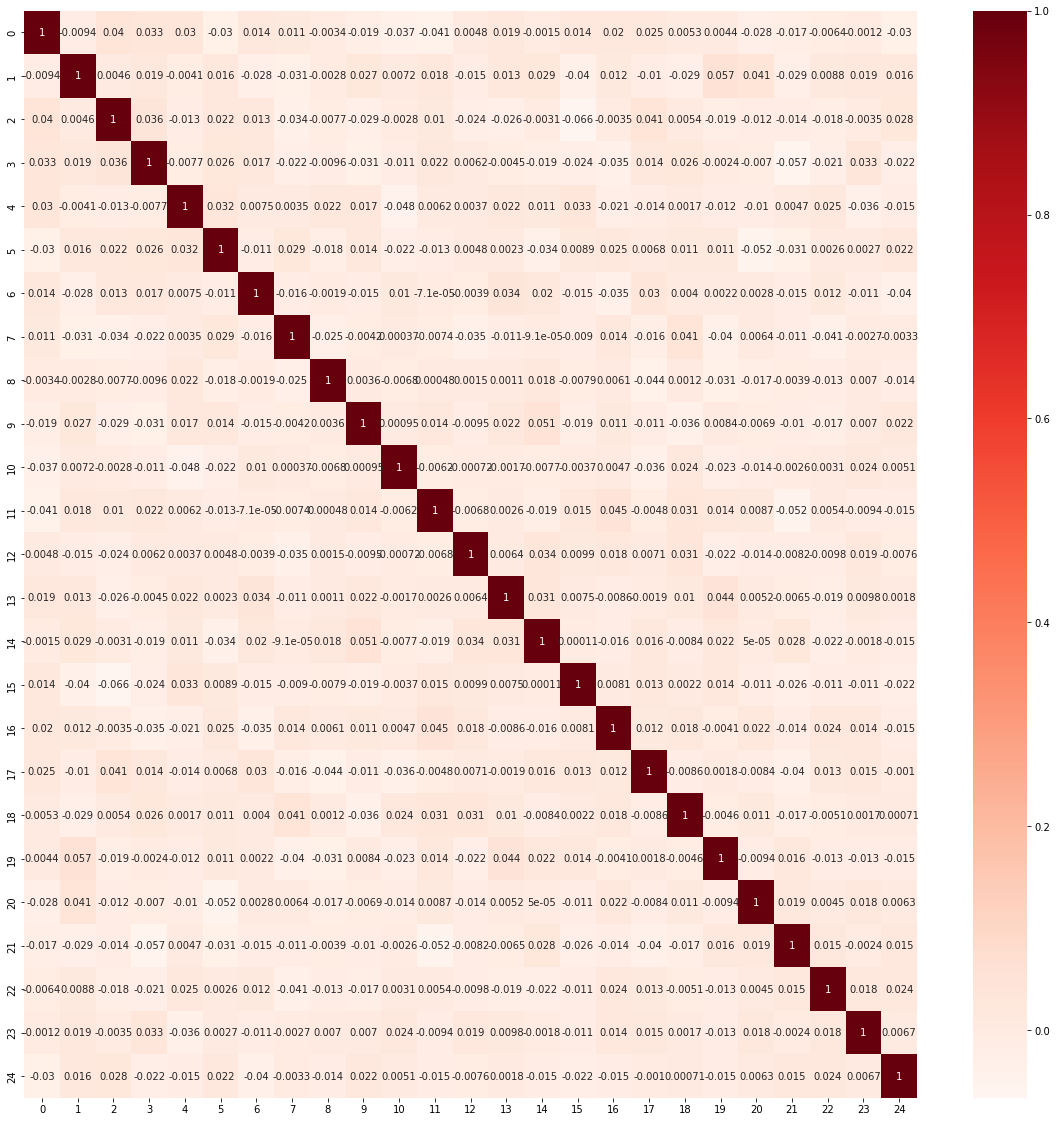

In [4]:
df_train = df.loc[:, [i for i in range(25)]]
df_test = df.loc[:, [25]]
plt.figure(figsize=(20,20))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
train_X = np.array(df_train.values)
train_y = np.array(df_test.values)

model = svm.SVC(kernel='rbf', gamma=0.05994842503189409, C=2.3135863551739546, coef0=0.)
rfe = RFE(model, 25)
X_rfe = rfe.fit_transform(train_X, train_y)
model.fit(X_rfe, train_y)
print(rfe.support_)
print(rfe.ranking_)

TypeError: __init__() takes 2 positional arguments but 3 were given

### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

split_frac=0.9
num_ft = 25
random_state = 42

df = pd.read_csv(file_name, header=None)
df_temp = df.sample(frac=1., random_state=random_state)

# SPLIT IN TRAIN AND TEST
train_df = df_temp[:int(split_frac*len(df_temp))]
test_df = df_temp[int(split_frac*len(df_temp)):]

# SPLIT BY FEATURES
X_train_temp = train_df.loc[:, [i for i in range(num_ft)]]
y_train_temp = train_df.loc[:, [25]]
X_test_temp = test_df.loc[:, [i for i in range(num_ft)]]
y_test_temp = test_df.loc[:, [25]]

train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)
test_X = np.array(X_test_temp.values)
test_y = np.array(y_test_temp.values)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

clf1 = svm.SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
clf2 = svm.SVC(kernel='poly', C=0.1, gamma=0.1, degree=3, probability=True)
clf3 = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
clf4 = svm.SVC(kernel='rbf', C=16.92666615037876, gamma=0.05011872336272722, probability=True)
clf5 = svm.SVC(kernel='rbf', C=25.118864315095795, gamma=0.05623413251903491, coef0=-0.4, probability=True) #Best
clf6 = svm.SVC(kernel='rbf', C=2.31, gamma=0.059, probability=True)
clf7 = svm.SVC(kernel='rbf', C=7.19, gamma=0.067, probability=True)
clf8 = svm.SVC(kernel='rbf', C=6.31, gamma=0.052, probability=True)

eclf1 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), 
                                     ('rbf5', clf5), ('rbf6', clf6), ('rbf7', clf7), ('rbf8', clf8)], voting='hard')
eclf2 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), 
                                     ('rbf5', clf5), ('rbf6', clf6), ('rbf7', clf7), ('rbf8', clf8)], voting='soft')
eclf3 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), ('rbf5', clf5), ('rbf6', clf6), 
                                     ('rbf7', clf7), ('rbf8', clf8)], voting='soft', weights=[2, 2, 2, 3, 5, 3, 3, 5])
eclf1 = eclf1.fit(train_X, np.ravel(train_y, order='C'))
eclf2 = eclf2.fit(train_X, np.ravel(train_y, order='C'))
eclf3 = eclf3.fit(train_X, np.ravel(train_y, order='C'))

print(eclf1.score(train_X, train_y))
print(eclf1.score(test_X, test_y))
print(eclf2.score(train_X, train_y))
print(eclf2.score(test_X, test_y))
print(eclf3.score(train_X, train_y))
print(eclf3.score(test_X, test_y))

In [ ]:
num_ft=25
df = pd.read_csv("train_set.csv", header=None)
df_temp = df.sample(frac=1., random_state=random_state)
print(len(df_temp))
X_train_temp = df_temp.loc[:, [i for i in range(num_ft)]]
y_train_temp = df_temp.loc[:, [25]]

train_X = np.array(X_train_temp.values)
train_y = np.array(y_train_temp.values)


df = pd.read_csv("test_set.csv", header=None)
df_temp = df
print(len(df_temp))

test_X = np.array(df_temp.values)
eclf1 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), 
                                     ('rbf5', clf5), ('rbf6', clf6), ('rbf7', clf7), ('rbf8', clf8)], voting='hard')
eclf2 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), 
                                     ('rbf5', clf5), ('rbf6', clf6), ('rbf7', clf7), ('rbf8', clf8)], voting='soft')
eclf3 = VotingClassifier(estimators=[('rbf1', clf1), ('poly2', clf2), ('rbf3', clf3), ('rbf4', clf4), ('rbf5', clf5), ('rbf6', clf6), 
                                     ('rbf7', clf7), ('rbf8', clf8)], voting='soft', weights=[2, 2, 2, 3, 5, 3, 3, 5])

eclf1 = eclf1.fit(train_X, np.ravel(train_y, order='C'))
print(eclf1.score(train_X, train_y))
pred_y = eclf1.predict(test_X)
print(pred_y)
eclf2 = eclf2.fit(train_X, np.ravel(train_y, order='C'))
print(eclf2.score(train_X, train_y))
pred_y2 = eclf2.predict(test_X)
print(pred_y2)
eclf3 = eclf3.fit(train_X, np.ravel(train_y, order='C'))
print(eclf3.score(train_X, train_y))
pred_y3 = eclf3.predict(test_X)
print(pred_y3)

In [ ]:
from datetime import datetime
now = datetime.now()
k = str(now).split(':')
p = k[0][-2:] + '_' + k[1] + '_' + k[2].split('.')[0]
p=k[0].split('-')[2][:2]+'_'+k[0].split('-')[1]+'_'+p
print(p)
save2csv("test_"+p+".csv", pred_y)